In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from ms_deisotope import deconvolute_peaks, averagine, scoring
from ms_deisotope.deconvolution import peak_retention_strategy
from os.path import expanduser
import peakutils
import pickle

In [2]:
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
experiment_name = 'P3856'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

# RESULTS_DIR = '/media/big-ssd/results-P3856'
# IDENTS_PASEF_DIR = '{}/P3856-results-cs-true-fmdw-true-2021-05-20-02-44-34/identifications-pasef'.format(RESULTS_DIR)

IDENTS_PASEF_DIR = '{}/identifications-pasef'.format(EXPERIMENT_DIR)
IDENTS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.pkl'.format(IDENTS_PASEF_DIR, experiment_name)

In [3]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = max(int(-1 * ((1.2 * mz_lower) - 1252)), 0)
    scan_for_mz_upper = max(int(-1 * ((1.2 * mz_upper) - 1252)), 0)
    return {'scan_for_mz_lower':scan_for_mz_lower, 'scan_for_mz_upper':scan_for_mz_upper}

In [4]:
# load the features identified
with open(IDENTS_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
idents_df = d['identifications_df']

In [5]:
idents_df['excluded'] = idents_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_df = idents_df[(idents_df.excluded == False)]

In [6]:
print('{} identifications'.format(len(idents_df)))

37251 identifications


In [7]:
idents_df[idents_df.deconvolution_score < 50].sample(n=5)

,mono_mz_lower,mono_mz_upper,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,intensity_without_saturation_correction,intensity_with_saturation_correction,...,percolator PEP,total matches/spectrum,sequence,protein id,flanking aa,observed_monoisotopic_mass,theoretical_peptide_mass,mass_accuracy_ppm,mass_error,excluded
71528,542.270441,542.304984,876.0,862,899,2128.363016,2122.011395,2135.770232,576,576,...,0.796749,14416.1,ILDHSLEEK,sp|Q8NFR7|CC148_HUMAN,KT,1082.561986,1082.560800,1.095299,0.001186,False
66841,785.011338,785.061344,688.0,682,726,2185.516772,2177.047888,2196.099979,741,741,...,1.000000,14416.1,SEEPPSERGGIFGSDGKDFVDK,sp|Q96EW2|HBAP1_HUMAN,RD,2352.094651,2352.086900,3.295269,0.007751,False
69018,1075.393971,1075.462475,267.0,228,300,1715.541945,1711.309877,1719.246419,1449,1449,...,1.000000,14416.1,MEGCM[15.9949]GEESFQMWELNR,sp|P48681|NEST_HUMAN,-R,2148.845641,2148.837264,3.898268,0.008377,False
66946,612.816399,612.855436,785.0,785,832,1684.316872,1681.141074,1684.316872,1295,1295,...,1.000000,14416.1,VSGGGEKVQHVK,sp|O00160|MYO1F_HUMAN,KD,1223.659190,1223.662200,-2.459999,-0.003010,False
65815,920.397163,920.455793,210.0,186,214,1918.787630,1916.142200,1921.963381,814,814,...,0.996243,14416.1,FYYNWK,sp|P53127|SNT2_YEAST,RK,919.418796,919.422800,-4.355152,-0.004004,False


In [8]:
selected_ident = idents_df.iloc[350]
# selected_ident = idents_df.loc[65477]

#### retention time similarity

In [9]:
max_intensity = 0
min_rt = np.finfo(0.0).max
max_rt = np.finfo(0.0).min
for isotope in selected_ident.isotopic_peaks:
    rt_df = pd.DataFrame(isotope['rt_df'])
    max_intensity = max(max_intensity, rt_df.intensity.max())
    max_rt = max(max_rt, rt_df.retention_time_secs.max())
    min_rt = min(min_rt, rt_df.retention_time_secs.min())

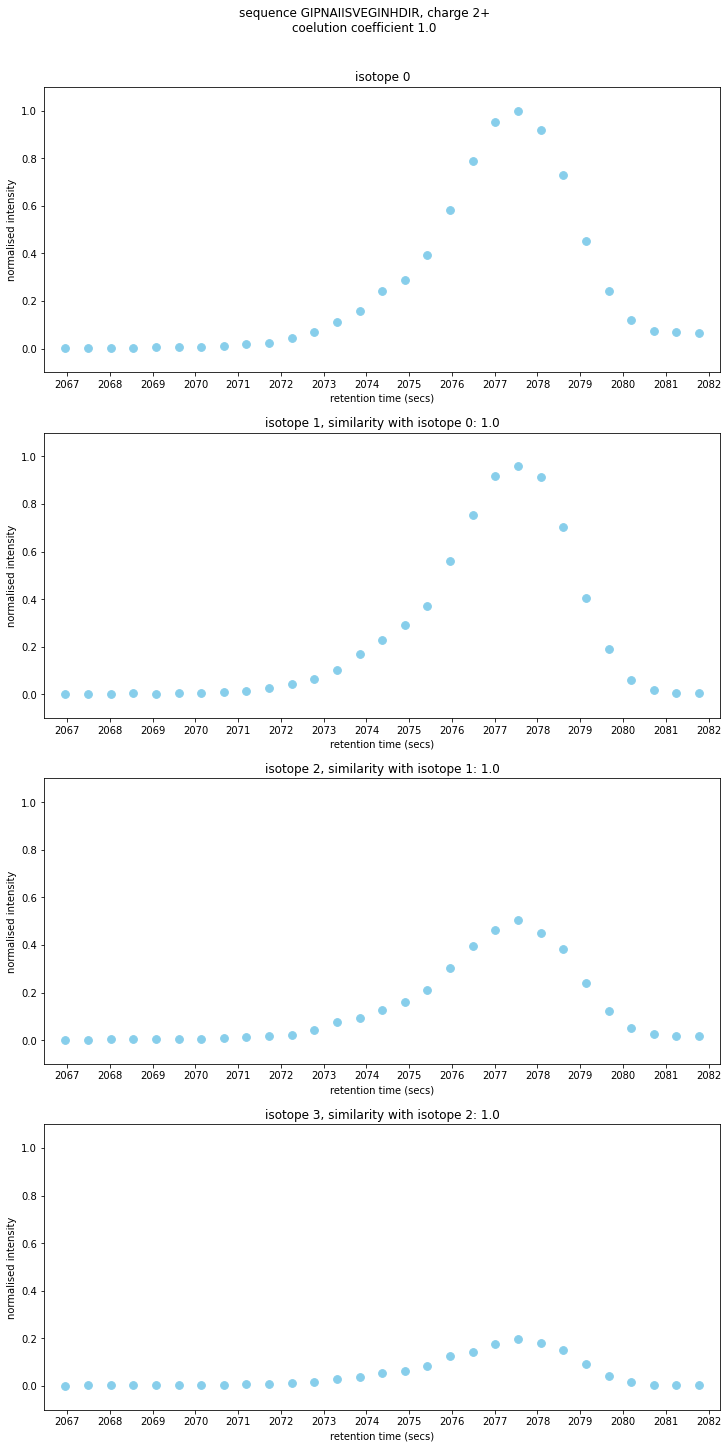

In [10]:
f, axarr = plt.subplots(nrows=len(selected_ident.isotopic_peaks), ncols=1, constrained_layout=True)
f.suptitle('sequence {}, charge {}+\ncoelution coefficient {}'.format(selected_ident.sequence, selected_ident.charge, round(selected_ident.coelution_coefficient,2), fontsize=18))
f.set_figheight(len(selected_ident.isotopic_peaks)*5)
f.set_figwidth(10)

# plot the features derived from deconvoluting the peaks
for idx,isotope in enumerate(selected_ident.isotopic_peaks):
    if len(selected_ident.isotopic_peaks) > 1:
        ax = axarr[idx]  # row, column
    else:
        ax = axarr

    # plot the raw data
    rt_df = pd.DataFrame(isotope['rt_df'])
    rt_df['normalised_intensity'] = rt_df.intensity / max_intensity
    ax.scatter(rt_df.retention_time_secs, rt_df.normalised_intensity, s=60, c='skyblue', label='summed points')

    nearest = 1.0
    range_l = round(rt_df.retention_time_secs.min() / nearest) * nearest
    range_u = round(rt_df.retention_time_secs.max() / nearest) * nearest
    ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

    ax.set_xlabel('retention time (secs)')
    ax.set_ylabel('normalised intensity')
    # ax.legend(loc='best')
    if idx > 0:
        ax.set_title('isotope {}, similarity with isotope {}: {}'.format(idx, idx-1, round(isotope['similarity_rt'],2)))
    else:
        ax.set_title('isotope {}'.format(idx))
    ax.set_xlim((min_rt-0.5,max_rt+0.5))
    ax.set_ylim((-0.1,1.1))
plt.show()

#### mobility similarity

In [11]:
max_intensity = 0
min_scan = np.iinfo(0).max
max_scan = np.iinfo(0).min
for isotope in selected_ident.isotopic_peaks:
    scan_df = pd.DataFrame(isotope['scan_df'])
    max_intensity = max(max_intensity, scan_df.intensity.max())
    max_scan = max(max_scan, scan_df.scan.max())
    min_scan = min(min_scan, scan_df.scan.min())    

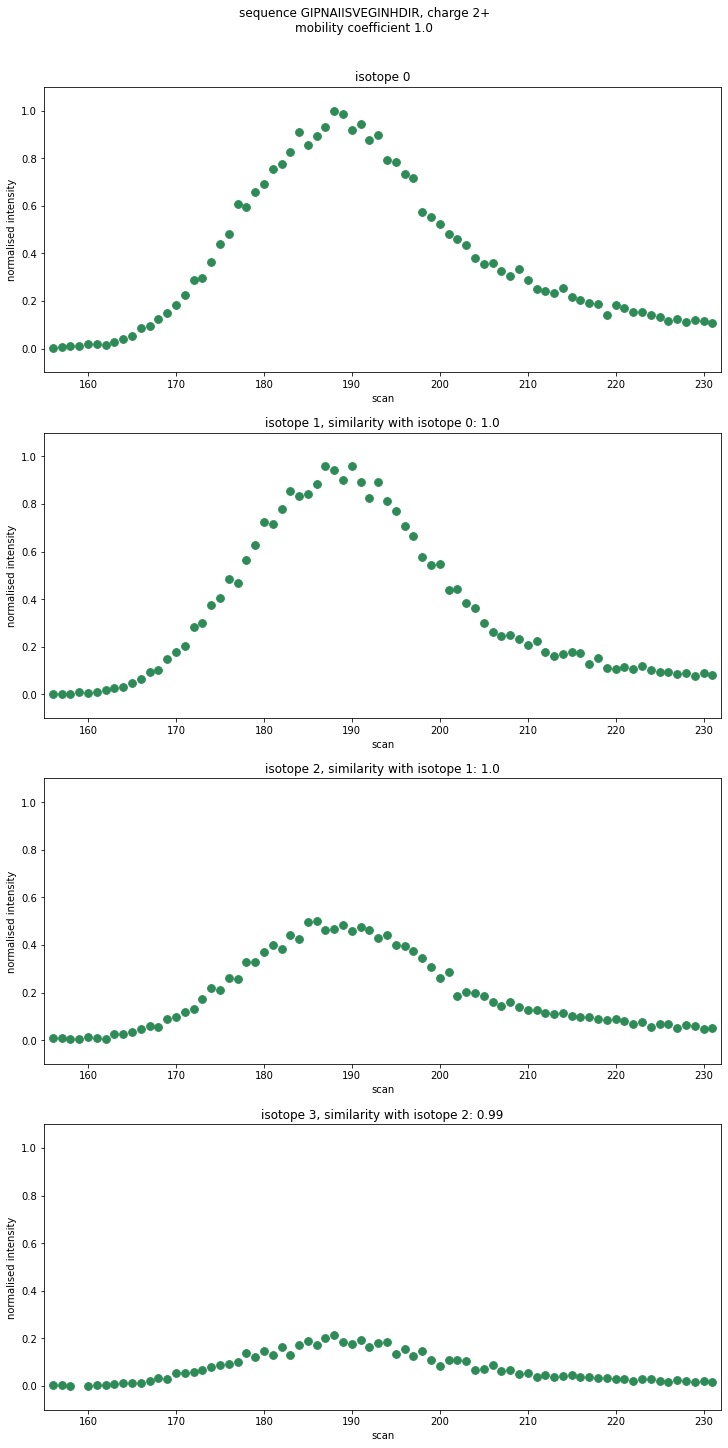

In [12]:
f, axarr = plt.subplots(nrows=len(selected_ident.isotopic_peaks), ncols=1, constrained_layout=True)
f.suptitle('sequence {}, charge {}+\nmobility coefficient {}'.format(selected_ident.sequence, selected_ident.charge, round(selected_ident.mobility_coefficient,2), fontsize=18))
f.set_figheight(len(selected_ident.isotopic_peaks)*5)
f.set_figwidth(10)

# plot the features derived from deconvoluting the peaks
for idx,isotope in enumerate(selected_ident.isotopic_peaks):
    if len(selected_ident.isotopic_peaks) > 1:
        ax = axarr[idx]  # row, column
    else:
        ax = axarr

    # plot the raw data
    scan_df = pd.DataFrame(isotope['scan_df'])
    scan_df['normalised_intensity'] = scan_df.intensity / max_intensity
    ax.scatter(scan_df.scan, scan_df.normalised_intensity, s=60, c='seagreen', label='summed points')

    nearest = 10.0
    range_l = round(scan_df.scan.min() / nearest) * nearest
    range_u = round(scan_df.scan.max() / nearest) * nearest
    ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

    ax.set_xlabel('scan')
    ax.set_ylabel('normalised intensity')
    # ax.legend(loc='best')
    if idx > 0:
        ax.set_title('isotope {}, similarity with isotope {}: {}'.format(idx, idx-1, round(isotope['similarity_scan'],2)))
    else:
        ax.set_title('isotope {}'.format(idx))
    ax.set_xlim((min_scan-1,max_scan+1))
    ax.set_ylim((-0.1,1.1))
plt.show()